### Implementation of the Fully Connected One Stage (FCOS) object detection algorithm with training/eval on the PASCAL VOC 2007 dataset. 

Make sure the data has been downloaded (http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar) and extracted. The 'JPEGImages' subdirectory contains all the raw jpeg images. The 'Annotations' subdirectory contains corresponding XML files with object detection labels/metadata. The 'ImageSets/Main' subdirectory contains .txt files 'train.txt', 'val.txt' which contain identifiers of images for training and validation splits respectively. (There are also additional .txt files containing identifiers for images per class for each split).

In [41]:
import os
import random
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt 
import torch
from torchvision import transforms

In [6]:
# first lets read in the image identifiers for train-val splits
with open(os.path.join('VOC2007_trainval', 'ImageSets', 'Main', 'train.txt')) as file:
    identifiers_train = [line.strip() for line in file.readlines()]

with open(os.path.join('VOC2007_trainval', 'ImageSets', 'Main', 'val.txt')) as file:
    identifiers_val = [line.strip() for line in file.readlines()]

# now get the jpeg filepaths for the images
image_filepaths_train = [os.path.join('VOC2007_trainval','JPEGImages',x+'.jpg') for x in identifiers_train]    
image_filepaths_val = [os.path.join('VOC2007_trainval','JPEGImages',x+'.jpg') for x in identifiers_val]    

# get the xml filepaths to object detection target labels
target_filepaths_train = [os.path.join('VOC2007_trainval','Annotations',x+'.xml') for x in identifiers_train]    
target_filepaths_val = [os.path.join('VOC2007_trainval','Annotations',x+'.xml') for x in identifiers_val]    

print(f"Num train images: {len(image_filepaths_train)}")
print(f"Num val images: {len(image_filepaths_val)}")

Num train images: 2501
Num val images: 2510


We will set up a pytorch Dataset object for accessing image-target pairs

In [65]:
class VOC2007(torch.utils.data.Dataset):
    def __init__(self, dataset_dir='VOC2007_trainval', split='train', image_size=224, num_boxes=40):
        super().__init__()
        self.image_size = image_size
        self.num_boxes = num_boxes # max number of object boxes per image

        # first lets read in the image identifiers for train-val splits
        with open(os.path.join(dataset_dir, 'ImageSets', 'Main', split+'.txt')) as file:
            identifiers = [line.strip() for line in file.readlines()]
        # now get the jpeg filepaths for the images
        self.image_filepaths = [os.path.join(dataset_dir,'JPEGImages',x+'.jpg') for x in identifiers]    
        # get the xml filepaths to object detection target labels
        self.target_filepaths = [os.path.join(dataset_dir,'Annotations',x+'.xml') for x in identifiers]    
        # get the target label annotations for all images
        self.image_annotations = [self.parse_xml(filepath) for filepath in self.target_filepaths]
        # class names
        voc_classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog",
            "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
        # class name <-> integer mapping
        self.class2idx = {c:i for i,c in enumerate(voc_classes)}
        self.idx2class = {i:c for i,c in enumerate(voc_classes)}
        
        # define transformations for image preprocessing
        self.transforms = transforms.Compose([
            transforms.Resize(self.image_size), # resize maintining original aspect ratio
            transforms.CenterCrop(self.image_size), # do center crop to make square image
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalzie to have same mean and std as ImageNet
        ])


    def __len__(self):
        return len(self.image_filepaths)

    def __getitem__(self, index):
        # get image filepath and annotations dictionary
        image_filepath, annotation = self.image_filepaths[index], self.image_annotations[index] 
        # load the RGB image
        image = Image.open(image_filepath).convert('RGB')
        # make tensor of class labels per box
        gt_classes = torch.tensor([self.class2idx[obj['class']] for obj in annotation['objects']]).unsqueeze(1) # shape: (N,1)
        # make tensor of boxes (N boxes, each with xyxy boundiong box coordinates)
        gt_boxes = torch.tensor([obj['bndbox'] for obj in annotation['objects']], dtype=torch.float) # shape: (N,4)
        # normalize bounding box coordinates to be in [0,1] w.r.t. original image size
        W, H = image.size
        norm = torch.tensor([[W,H,W,H]])
        gt_boxes /= norm 
        # preprocess image, transform to tensor
        image = self.transforms(image)    
       
        # now transform the bounding boxes accordingly to match the transformed image dimensions
        if H >= W:
            # size of transforms.Resize() 
            # (if H>=W, then transforms.Resize() output size will be (H*image_size/W, image_size) else output size will be (image_size,W*image_size/H))
            H_new = H * self.image_size / W
            W_new = self.image_size 
        else:
            H_new = self.image_size
            W_new = W * self.image_size / H
        # center-crop shift amount        
        dxc = (W_new - self.image_size) // 2    
        dyc = (H_new - self.image_size) // 2    

        # unnormalize bounding box coordinates and shift for center-crop, also clamp to (0,image_size)
        gt_boxes[:,0] = torch.clamp(gt_boxes[:,0] * W_new - dxc ,min=0)
        gt_boxes[:,1] = torch.clamp(gt_boxes[:,1] * H_new - dyc ,min=0)
        gt_boxes[:,2] = torch.clamp(gt_boxes[:,2] * W_new - dxc ,max=self.image_size)
        gt_boxes[:,3] = torch.clamp(gt_boxes[:,3] * H_new - dyc ,max=self.image_size)

        # concatenate bounding box coordinates and class labels into single tensor of shape (N,5)
        gt_boxes = torch.cat([gt_boxes, gt_classes], dim=1)
        # set invalid boxes to -1
        invalid = (gt_boxes[:,0] > gt_boxes[:,2]) | (gt_boxes[:,1] > gt_boxes[:,3]) 
        gt_boxes[invalid] = -1
        # apply padding to make N fixed size
        gt_boxes = torch.cat([gt_boxes[:self.num_boxes], torch.full((self.num_boxes-len(gt_boxes),5), -1.0)])

        return image_filepath, image, gt_boxes

    # fucntion for parsing XML file to get object detection target labels
    def parse_xml(self, filepath):
        # start at the root of the XML tree
        root_node = ET.parse(filepath).getroot()
        annotations = {}
        # get all the object bounding boxes
        objects = []
        for obj in root_node.findall('object'):
            # for each object, get class name, difficulty identifier (0: easy, 1: difficult) and bounding box (xyxy: top-left and bottom-right corner coordinates) 
            object_dict = {
                'class': obj.find('name').text,
                'difficult': obj.find('difficult').text,
                'bndbox': [int(obj.find('bndbox/xmin').text), 
                           int(obj.find('bndbox/ymin').text),
                           int(obj.find('bndbox/xmax').text), 
                           int(obj.find('bndbox/ymax').text)]

            }
            objects.append(object_dict)
        annotations['objects'] = objects
        return annotations    
    

# tranform for unnormalizing an image from the dataset
unnormalize = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]), 
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]) ])    

# function for visualizing image with target boxes
def visualize(dataset, index=None):
    if not index:
        # grab a random image from dataset if no index provided
        index = random.randint(0,len(dataset)-1)
    _, image, gt_boxes = dataset[index]

    # unnormalize the image
    image = unnormalize(image)
    # only keep non-padding boxes
    nonpad = gt_boxes[:,4]>=0
    gt_boxes = gt_boxes[nonpad]
    # reshape image from (C,H,W) -> (H,W,C) and conert to numpy uint array
    image = (image *255).permute(1,2,0).numpy().astype("uint8")
    # plot image
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.axis("off")
    # plot object bounding boxes with class label
    for i in range(len(gt_boxes)):
        xmin, ymin, xmax, ymax = gt_boxes[i,0:4]
        class_label = dataset.idx2class[gt_boxes[i,-1].item()]
        print(f"gt box coords: {xmin, ymin, xmax, ymax }, label: {class_label}")
        rectangle = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=3, linestyle="solid", edgecolor='r', fill=False)
        ax.add_patch(rectangle)
        ax.text(xmin, ymin, class_label, size=18, family="sans-serif", 
                bbox={"facecolor": "black", "alpha": 0.8,"pad": 0.7, "edgecolor": "none"},
                verticalalignment="top", color=(1, 1, 1), zorder=10,)

    plt.show()


In [66]:
# create train-val datasets
train_dataset = VOC2007(split='train')
val_dataset = VOC2007(split='val')

gt box coords: (tensor(14.0987), tensor(64.0810), tensor(198.9696), tensor(171.2608)), label: train
gt box coords: (tensor(181.9570), tensor(116.8203), tensor(199.5367), tensor(162.7544)), label: person


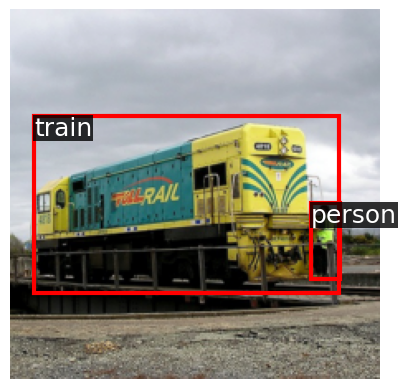

In [90]:
visualize(train_dataset)